In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchvision import transforms
import torchvision.models as models  
from torchvision.transforms import Resize, RandomAffine, ToTensor, ToPILImage,  RandomErasing

from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification

import random
from PIL import Image, ImageEnhance 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import timm

In [2]:
# CSV FILE PATHS MAPPING
# Paths to the CSV files and image folder
train_csv_path = 'bookcover30/Task1/book30-listing-train.csv'
test_csv_path = 'bookcover30/Task1/book30-listing-test.csv'
image_folder = 'bookcover30/bookcover_images'

# Load train and test data from CSV files
train_data = pd.read_csv(train_csv_path, header=None, encoding='ISO-8859-1')
test_data = pd.read_csv(test_csv_path, header=None, encoding='ISO-8859-1')

# Extract text, label, and filename columns
# Column indices are based on the CSV structure 0-based
# Titles are in column 4
# Labels are in column 7
# Image filenames are in column 2

train_texts = train_data.iloc[:, 3].tolist() 
train_titles = train_data.iloc[:, 3].tolist() 
train_labels = train_data.iloc[:, 6].tolist()  
train_filenames = train_data.iloc[:, 1].tolist()  

test_texts = test_data.iloc[:, 3].tolist()
test_titles = test_data.iloc[:, 3].tolist()
test_labels = test_data.iloc[:, 6].tolist()
test_filenames = test_data.iloc[:, 1].tolist() 

# Prepend the image folder path to the filenames for both train and test data

train_filenames = [os.path.join(image_folder, fname) for fname in train_filenames]
test_filenames = [os.path.join(image_folder, fname) for fname in test_filenames]

# Get the unique labels and create a mapping
label_names = [str(label) for label in sorted(np.unique(train_labels))]
label_to_index = {name: index for index, name in enumerate(label_names)}

# Encode the labels
train_labels_encoded = np.array([label_to_index[label] for label in train_labels])
test_labels_encoded = np.array([label_to_index[label] for label in test_labels])

In [3]:
# DATASET FUNCTION
class CustomDataset(Dataset):
    def __init__(self, titles, tokenizer, max_len, labels):
        self.labels = labels
        self.titles = titles
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.titles)
        
    def __getitem__(self, idx):
        label = self.labels[idx]

        # Text data (Book title)
        book_title = self.titles[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            book_title,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        text_input_id = encoding["input_ids"].squeeze(0)
        text_attention_mask = encoding["attention_mask"].squeeze(0)
        
        return text_input_id, text_attention_mask, label  # Return multiple tensors for Parallel-ViT setup

In [ ]:
# SETTINGS
output_dir = "MER/03_bert"
model_name = 'bert-base-uncased'
max_len = 128
new_dropout_rate = 0.35  # Desired dropout rate
BATCH_SIZE = 32
learning_rate = 1e-5
weight_decay = 1e-4

In [ ]:
# INITIALIZING THE BERT MODEL CONFIG
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification

# Tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

config = BertConfig.from_pretrained(
    model_name, 
    num_labels=30, 
    hidden_dropout_prob=new_dropout_rate, 
    attention_probs_dropout_prob=new_dropout_rate
)

# # Model
# model = BertForSequenceClassification.from_pretrained(model_name, config=config)  # Use the updated configuration

In [ ]:
# from transformers import DistilBertTokenizer, DistilBertConfig, DistilBertForSequenceClassification

# # Tokenizer
# tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# # Config
# config = DistilBertConfig.from_pretrained(
#     model_name,
#     num_labels=30,
#     dropout=new_dropout_rate,  # DistilBERT uses 'dropout' and 'attention_dropout'
#     attention_dropout=new_dropout_rate
# )

# # Model
# model = DistilBertForSequenceClassification.from_pretrained(model_name, config=config)

In [7]:
# from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification

# # Tokenizer
# tokenizer = RobertaTokenizer.from_pretrained(model_name)

# # Config
# config = RobertaConfig.from_pretrained(
#     model_name, 
#     num_labels=30, 
#     hidden_dropout_prob=new_dropout_rate, 
#     attention_probs_dropout_prob=new_dropout_rate
# )

# # Model
# model = RobertaForSequenceClassification.from_pretrained(model_name, config=config)

In [8]:
# DATASET INITIALIZATION
# Dataset
train_dataset = CustomDataset(train_titles, tokenizer, max_len, train_labels_encoded)
test_dataset = CustomDataset(test_titles, tokenizer, max_len, test_labels_encoded)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# TRAINING LOOP
import logging 
# 🔹 Configure Logging
logging.basicConfig(
    filename=f"logs/{output_dir}.log",  # Save logs to this file
    filemode="a",  # Append logs each run 
    format="%(asctime)s - %(levelname)s - %(message)s",  
    level=logging.INFO  # Set logging level
)
logger = logging.getLogger()

def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs, use_scheduler, warmup):
    model.to(device)
    train_losses = []
    test_accuracies_top1 = []
    test_accuracies_top3 = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, total = 0.0, 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        for input_ids, attention_mask, labels in progress_bar:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)  # Access logits attribute
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            total += labels.size(0)
            
            progress_bar.set_postfix(loss=running_loss / (total / len(labels)))
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # ✅ Log training loss
        log_msg = f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}"
        print(log_msg)
        logger.info(log_msg) 
        
        current_lr = optimizer.param_groups[0]['lr']
        if use_scheduler:
            print(f"Learning Rate: {current_lr:.8f}")
        
        # ✅ Evaluate on test set
        test_acc1, test_acc3, all_preds, all_labels = evaluate_model(model, test_loader, device)
        test_accuracies_top1.append(test_acc1)
        test_accuracies_top3.append(test_acc3)

        # ✅ Log evaluation results
        eval_msg = f"Epoch [{epoch+1}/{num_epochs}], Test Top-1 Accuracy: {test_acc1:.2f}%, Test Top-3 Accuracy: {test_acc3:.2f}%"
        print(eval_msg)
        logger.info(eval_msg)

    print("Training complete!")
    logger.info("Training complete!")

    return train_losses, test_accuracies_top1, test_accuracies_top3, all_preds, all_labels

In [ ]:
# MULTI-RUNS FUNCTION
def run_multiple_times(train_loader, test_loader, num_epochs=10, use_scheduler=False, warmup=0.2, num_runs=3):
    best_top1 = -float('inf')  # Initialize to a very low value
    best_top3 = 0
    saved_loss, saved_top1, saved_top3, preds, labels = [], [], [], [], []
    
    # Initialize best model state dictionary
    best_model_state_dict = None

    for run in range(1, num_runs + 1):
        separator = f"\n{'=' * 40}\n RUN {run} / {num_runs} \n{'=' * 40}\n"
        print(separator)
        logger.info(separator)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Model
        model = BertForSequenceClassification.from_pretrained(model_name, config=config)
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        
        # Define optimizer using Adam
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Train the model
        train_losses, test_accuracies_top1, test_accuracies_top3, all_preds, all_labels = train_model(
            model, train_loader, test_loader, criterion, optimizer, device, num_epochs, use_scheduler, warmup
        )
        
        # Get the last value of test_accuracies_top1 for the current run
        current_top1 = test_accuracies_top1[-1]
        
        # Check if the current run has the best top-1 accuracy so far
        if current_top1 > best_top1:
            best_top1 = current_top1
            best_top3 = test_accuracies_top3[-1]  # Update top-3 accuracy
            
            # Save the results for the best run
            saved_loss = train_losses
            saved_top1 = test_accuracies_top1
            saved_top3 = test_accuracies_top3
            preds = all_preds
            labels = all_labels

            # Define save paths
            save_path = f"saves/models/{output_dir}"
            
            # Save only state_dict
            model.save_pretrained(save_path)
            
            # Optionally, print out the best performance
            print(f"New best top-1 accuracy: {best_top1:.4f}. Model saved.")

    return saved_loss, saved_top1, saved_top3, preds, labels

In [ ]:
# EVAL-MODEL FUNCTION
def evaluate_model(model, test_loader, device):
    model.eval()
    correct_top1, correct_top3, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for input_ids, attention_masks, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
                
            # 🔹 Compute Top-1 and Top-3 Accuracy
            _, pred_top1 = torch.max(outputs.logits, 1)  # Access logits attribute
            _, pred_top3 = outputs.logits.topk(3, dim=1)  # Get top 3 predictions

            correct_top1 += (pred_top1.squeeze() == labels).sum().item()
            correct_top3 += (labels.unsqueeze(1) == pred_top3).sum().item()
            total += labels.size(0)

            all_preds.extend(pred_top1.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 🔹 Compute Accuracy Percentages
    test_acc1 = 100 * correct_top1 / total
    test_acc3 = 100 * correct_top3 / total

    print(f"Test Top-1 Accuracy: {test_acc1:.2f}% | Test Top-3 Accuracy: {test_acc3:.2f}%")
    return test_acc1, test_acc3, all_preds, all_labels

In [ ]:
# PLOT LOSS/CONF-MATRIX FUNCTION
def plot_training_results(train_losses, test_accuracies_top1, test_accuracies_top3, all_preds, all_labels, output_dir):
    # Plot training loss and accuracy
    plt.figure(figsize=(12, 4))
    epochs = range(1, num_epochs + 1)
    
    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", linestyle='-', color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    
    # Plot Test Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies_top1, label="Test Top-1 Accuracy", color='green')
    plt.plot(epochs, test_accuracies_top3, label="Test Top-3 Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Test Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()

    # Save the figure as a file
    plt.savefig(f"saves/graphs/{output_dir}_loss-accuracy.png", bbox_inches='tight')  # Save as PNG
    plt.show()
    plt.close()  # Close the current figure

    # Convert lists to NumPy arrays for confusion matrix
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    # Save the confusion matrix as a file
    plt.savefig(f"saves/graphs/{output_dir}_conf-matrix.png", bbox_inches='tight')  # Save as PNG
    plt.show()
    plt.close()  # Close the current figure

    print(f"Figures saved to {output_dir}")


 RUN 1 / 5 



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                                                                                                        

Epoch [1/10], Loss: 2.3204


Test Top-1 Accuracy: 54.61% | Test Top-3 Accuracy: 74.91%
Epoch [1/10], Test Top-1 Accuracy: 54.61%, Test Top-3 Accuracy: 74.91%


Epoch [2/10], Loss: 1.6464


Test Top-1 Accuracy: 57.63% | Test Top-3 Accuracy: 78.40%
Epoch [2/10], Test Top-1 Accuracy: 57.63%, Test Top-3 Accuracy: 78.40%


Epoch [3/10], Loss: 1.4907


Test Top-1 Accuracy: 59.54% | Test Top-3 Accuracy: 80.14%
Epoch [3/10], Test Top-1 Accuracy: 59.54%, Test Top-3 Accuracy: 80.14%


Epoch [4/10], Loss: 1.3870


Test Top-1 Accuracy: 60.11% | Test Top-3 Accuracy: 80.70%
Epoch [4/10], Test Top-1 Accuracy: 60.11%, Test Top-3 Accuracy: 80.70%


Epoch [5/10], Loss: 1.3081


Test Top-1 Accuracy: 60.82% | Test Top-3 Accuracy: 81.23%
Epoch [5/10], Test Top-1 Accuracy: 60.82%, Test Top-3 Accuracy: 81.23%


Epoch [6/10], Loss: 1.2363


Test Top-1 Accuracy: 61.58% | Test Top-3 Accuracy: 80.91%
Epoch [6/10], Test Top-1 Accuracy: 61.58%, Test Top-3 Accuracy: 80.91%


Epoch [7/10], Loss: 1.1774


Test Top-1 Accuracy: 61.46% | Test Top-3 Accuracy: 81.75%
Epoch [7/10], Test Top-1 Accuracy: 61.46%, Test Top-3 Accuracy: 81.75%


Epoch [8/10], Loss: 1.1322


Test Top-1 Accuracy: 62.23% | Test Top-3 Accuracy: 81.63%
Epoch [8/10], Test Top-1 Accuracy: 62.23%, Test Top-3 Accuracy: 81.63%


Epoch [9/10], Loss: 1.0761


Test Top-1 Accuracy: 62.44% | Test Top-3 Accuracy: 82.19%
Epoch [9/10], Test Top-1 Accuracy: 62.44%, Test Top-3 Accuracy: 82.19%


Epoch [10/10], Loss: 1.0281


Test Top-1 Accuracy: 62.25% | Test Top-3 Accuracy: 81.46%
Epoch [10/10], Test Top-1 Accuracy: 62.25%, Test Top-3 Accuracy: 81.46%
Training complete!
New best top-1 accuracy: 62.2456. Model saved.

 RUN 2 / 5 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                                                                                                        

Epoch [1/10], Loss: 2.2846


Test Top-1 Accuracy: 54.51% | Test Top-3 Accuracy: 75.79%
Epoch [1/10], Test Top-1 Accuracy: 54.51%, Test Top-3 Accuracy: 75.79%


Epoch [2/10], Loss: 1.6267


Test Top-1 Accuracy: 57.75% | Test Top-3 Accuracy: 78.91%
Epoch [2/10], Test Top-1 Accuracy: 57.75%, Test Top-3 Accuracy: 78.91%


Epoch [3/10], Loss: 1.4772


Test Top-1 Accuracy: 59.54% | Test Top-3 Accuracy: 80.51%
Epoch [3/10], Test Top-1 Accuracy: 59.54%, Test Top-3 Accuracy: 80.51%


Epoch [4/10], Loss: 1.3835


Test Top-1 Accuracy: 60.82% | Test Top-3 Accuracy: 80.86%
Epoch [4/10], Test Top-1 Accuracy: 60.82%, Test Top-3 Accuracy: 80.86%


Epoch [5/10], Loss: 1.3002


Test Top-1 Accuracy: 61.46% | Test Top-3 Accuracy: 81.61%
Epoch [5/10], Test Top-1 Accuracy: 61.46%, Test Top-3 Accuracy: 81.61%


Epoch [6/10], Loss: 1.2296


Test Top-1 Accuracy: 61.82% | Test Top-3 Accuracy: 81.54%
Epoch [6/10], Test Top-1 Accuracy: 61.82%, Test Top-3 Accuracy: 81.54%


Epoch [7/10], Loss: 1.1786


Test Top-1 Accuracy: 61.89% | Test Top-3 Accuracy: 81.84%
Epoch [7/10], Test Top-1 Accuracy: 61.89%, Test Top-3 Accuracy: 81.84%


Epoch [8/10], Loss: 1.1233


Test Top-1 Accuracy: 61.91% | Test Top-3 Accuracy: 81.72%
Epoch [8/10], Test Top-1 Accuracy: 61.91%, Test Top-3 Accuracy: 81.72%


Epoch [9/10], Loss: 1.0676


Test Top-1 Accuracy: 62.51% | Test Top-3 Accuracy: 82.04%
Epoch [9/10], Test Top-1 Accuracy: 62.51%, Test Top-3 Accuracy: 82.04%


Epoch [10/10], Loss: 1.0205


Test Top-1 Accuracy: 62.91% | Test Top-3 Accuracy: 82.51%
Epoch [10/10], Test Top-1 Accuracy: 62.91%, Test Top-3 Accuracy: 82.51%
Training complete!


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


New best top-1 accuracy: 62.9123. Model saved.

 RUN 3 / 5 



Epoch [1/10], Loss: 2.2832


Test Top-1 Accuracy: 54.51% | Test Top-3 Accuracy: 75.39%
Epoch [1/10], Test Top-1 Accuracy: 54.51%, Test Top-3 Accuracy: 75.39%


Epoch [2/10], Loss: 1.6306


Test Top-1 Accuracy: 57.46% | Test Top-3 Accuracy: 78.46%
Epoch [2/10], Test Top-1 Accuracy: 57.46%, Test Top-3 Accuracy: 78.46%


Epoch [3/10], Loss: 1.4818


Test Top-1 Accuracy: 59.58% | Test Top-3 Accuracy: 79.65%
Epoch [3/10], Test Top-1 Accuracy: 59.58%, Test Top-3 Accuracy: 79.65%


Epoch [4/10], Loss: 1.3834


Test Top-1 Accuracy: 60.53% | Test Top-3 Accuracy: 80.70%
Epoch [4/10], Test Top-1 Accuracy: 60.53%, Test Top-3 Accuracy: 80.70%


Epoch [5/10], Loss: 1.3020


Test Top-1 Accuracy: 60.96% | Test Top-3 Accuracy: 80.86%
Epoch [5/10], Test Top-1 Accuracy: 60.96%, Test Top-3 Accuracy: 80.86%


Epoch [6/10], Loss: 1.2353


Test Top-1 Accuracy: 61.30% | Test Top-3 Accuracy: 81.58%
Epoch [6/10], Test Top-1 Accuracy: 61.30%, Test Top-3 Accuracy: 81.58%


Epoch [7/10], Loss: 1.1777


Test Top-1 Accuracy: 61.82% | Test Top-3 Accuracy: 81.81%
Epoch [7/10], Test Top-1 Accuracy: 61.82%, Test Top-3 Accuracy: 81.81%


Epoch [8/10], Loss: 1.1181


Test Top-1 Accuracy: 61.79% | Test Top-3 Accuracy: 81.82%
Epoch [8/10], Test Top-1 Accuracy: 61.79%, Test Top-3 Accuracy: 81.82%


Epoch [9/10], Loss: 1.0760


Test Top-1 Accuracy: 62.39% | Test Top-3 Accuracy: 82.11%
Epoch [9/10], Test Top-1 Accuracy: 62.39%, Test Top-3 Accuracy: 82.11%


Epoch [10/10], Loss: 1.0171


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Top-1 Accuracy: 62.35% | Test Top-3 Accuracy: 82.23%
Epoch [10/10], Test Top-1 Accuracy: 62.35%, Test Top-3 Accuracy: 82.23%
Training complete!

 RUN 4 / 5 



Epoch [1/10], Loss: 2.2831


Test Top-1 Accuracy: 54.32% | Test Top-3 Accuracy: 75.26%
Epoch [1/10], Test Top-1 Accuracy: 54.32%, Test Top-3 Accuracy: 75.26%


Epoch [2/10], Loss: 1.6322


Test Top-1 Accuracy: 57.67% | Test Top-3 Accuracy: 78.51%
Epoch [2/10], Test Top-1 Accuracy: 57.67%, Test Top-3 Accuracy: 78.51%


Epoch [3/10], Loss: 1.4782


Test Top-1 Accuracy: 59.56% | Test Top-3 Accuracy: 80.12%
Epoch [3/10], Test Top-1 Accuracy: 59.56%, Test Top-3 Accuracy: 80.12%


Epoch [4/10], Loss: 1.3788


Test Top-1 Accuracy: 60.54% | Test Top-3 Accuracy: 80.84%
Epoch [4/10], Test Top-1 Accuracy: 60.54%, Test Top-3 Accuracy: 80.84%


Epoch [5/10], Loss: 1.3006


Test Top-1 Accuracy: 61.14% | Test Top-3 Accuracy: 81.74%
Epoch [5/10], Test Top-1 Accuracy: 61.14%, Test Top-3 Accuracy: 81.74%


Epoch [6/10], Loss: 1.2352


Test Top-1 Accuracy: 61.40% | Test Top-3 Accuracy: 82.00%
Epoch [6/10], Test Top-1 Accuracy: 61.40%, Test Top-3 Accuracy: 82.00%


Epoch [7/10], Loss: 1.1778


Test Top-1 Accuracy: 61.84% | Test Top-3 Accuracy: 81.93%
Epoch [7/10], Test Top-1 Accuracy: 61.84%, Test Top-3 Accuracy: 81.93%


Epoch [8/10], Loss: 1.1222


Test Top-1 Accuracy: 62.37% | Test Top-3 Accuracy: 81.98%
Epoch [8/10], Test Top-1 Accuracy: 62.37%, Test Top-3 Accuracy: 81.98%


Epoch [9/10], Loss: 1.0700


Test Top-1 Accuracy: 62.26% | Test Top-3 Accuracy: 82.21%
Epoch [9/10], Test Top-1 Accuracy: 62.26%, Test Top-3 Accuracy: 82.21%


Epoch [10/10], Loss: 1.0171


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Top-1 Accuracy: 62.63% | Test Top-3 Accuracy: 82.23%
Epoch [10/10], Test Top-1 Accuracy: 62.63%, Test Top-3 Accuracy: 82.23%
Training complete!

 RUN 5 / 5 



Epoch [1/10], Loss: 2.2851


Test Top-1 Accuracy: 54.32% | Test Top-3 Accuracy: 75.39%
Epoch [1/10], Test Top-1 Accuracy: 54.32%, Test Top-3 Accuracy: 75.39%


Epoch [2/10], Loss: 1.6309


Test Top-1 Accuracy: 58.09% | Test Top-3 Accuracy: 78.40%
Epoch [2/10], Test Top-1 Accuracy: 58.09%, Test Top-3 Accuracy: 78.40%


Epoch [3/10], Loss: 1.4776


Test Top-1 Accuracy: 59.46% | Test Top-3 Accuracy: 79.82%
Epoch [3/10], Test Top-1 Accuracy: 59.46%, Test Top-3 Accuracy: 79.82%


Epoch [4/10], Loss: 1.3753


Test Top-1 Accuracy: 60.58% | Test Top-3 Accuracy: 81.00%
Epoch [4/10], Test Top-1 Accuracy: 60.58%, Test Top-3 Accuracy: 81.00%


Epoch [5/10], Loss: 1.3009


Test Top-1 Accuracy: 61.07% | Test Top-3 Accuracy: 81.75%
Epoch [5/10], Test Top-1 Accuracy: 61.07%, Test Top-3 Accuracy: 81.75%


Epoch [6/10], Loss: 1.2298


Test Top-1 Accuracy: 62.19% | Test Top-3 Accuracy: 81.53%
Epoch [6/10], Test Top-1 Accuracy: 62.19%, Test Top-3 Accuracy: 81.53%


Epoch [7/10], Loss: 1.1690


Test Top-1 Accuracy: 62.12% | Test Top-3 Accuracy: 82.07%
Epoch [7/10], Test Top-1 Accuracy: 62.12%, Test Top-3 Accuracy: 82.07%


Epoch [8/10], Loss: 1.1197


Test Top-1 Accuracy: 62.11% | Test Top-3 Accuracy: 82.32%
Epoch [8/10], Test Top-1 Accuracy: 62.11%, Test Top-3 Accuracy: 82.32%


Epoch [9/10], Loss: 1.0644


Test Top-1 Accuracy: 62.54% | Test Top-3 Accuracy: 82.26%
Epoch [9/10], Test Top-1 Accuracy: 62.54%, Test Top-3 Accuracy: 82.26%


Epoch [10/10], Loss: 1.0187


Test Top-1 Accuracy: 62.75% | Test Top-3 Accuracy: 82.53%
Epoch [10/10], Test Top-1 Accuracy: 62.75%, Test Top-3 Accuracy: 82.53%
Training complete!


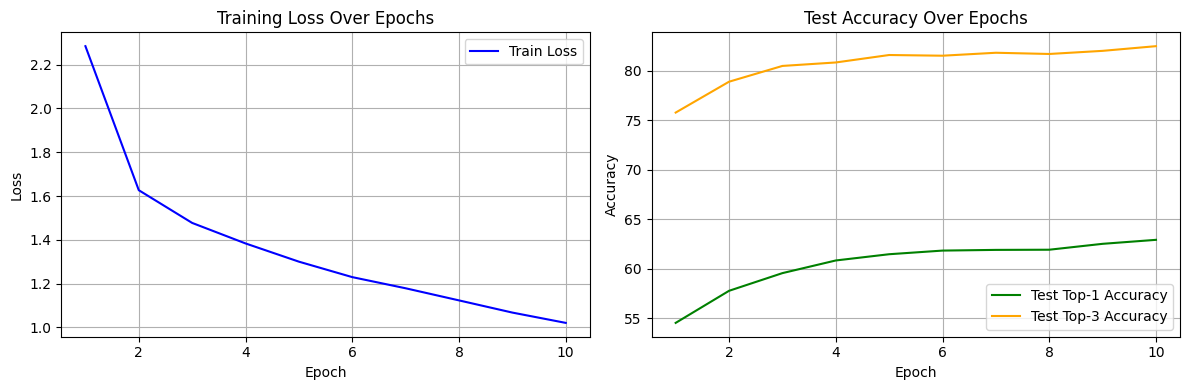

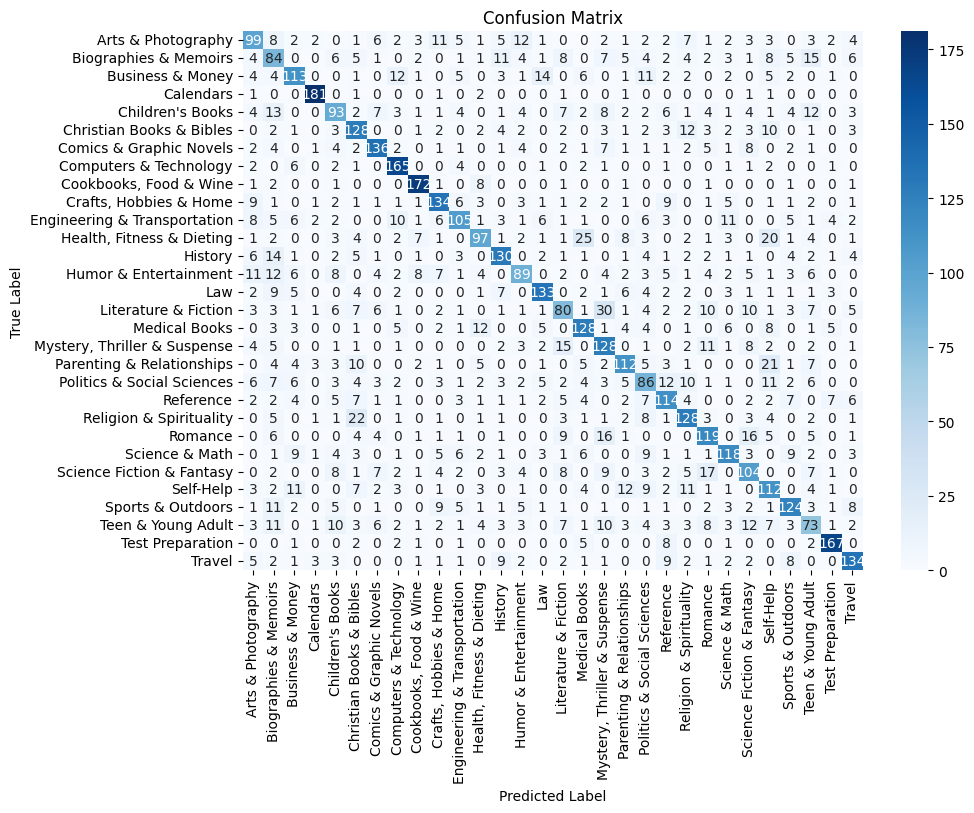

Figures saved to TXT/02_distilbert


In [13]:
class_names = list(label_names)
num_epochs=10

train_losses, test_accuracies_top1, test_accuracies_top3, all_preds, all_labels = run_multiple_times(
    train_loader=train_loader,
    test_loader=test_loader, 
    num_epochs=num_epochs, 
    use_scheduler=False,
    warmup = 0.2,
    num_runs=5
)

# Plot the results
plot_training_results(train_losses, test_accuracies_top1, test_accuracies_top3, all_preds, all_labels, output_dir)